In [5]:
from pathlib import Path
from opensoundscape.spectrogram import MelSpectrogram
from opensoundscape import Audio


raw_root = Path("~/shared/birdclef/raw/birdclef-2025").expanduser()
soundscape_root = raw_root / "train_soundscapes"
soundscapes = sorted(soundscape_root.glob("*.ogg"))
print(soundscapes[:3])

[PosixPath('/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/raw/birdclef-2025/train_soundscapes/H02_20230420_074000.ogg'), PosixPath('/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/raw/birdclef-2025/train_soundscapes/H02_20230420_112000.ogg'), PosixPath('/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/raw/birdclef-2025/train_soundscapes/H02_20230420_154500.ogg')]


We're going to get about 16 MFCC frames per second of audio. To achieve this we have the following parameters on our data:

- 32khz sample rate on audio
- 8 frames a second (64 frames per 8 seconds, 128 per 16 seconds)
- hop length of 4000 samples (32khz * 0.125 seconds)
- window samples with 50% overlap 2*hop length (8000 samples, 250ms)
- fft size of 8000 -> 8192 for efficiency
- n mels of 128
- no db scaling since we're going to use the raw values for mfcc
- n mfccs 

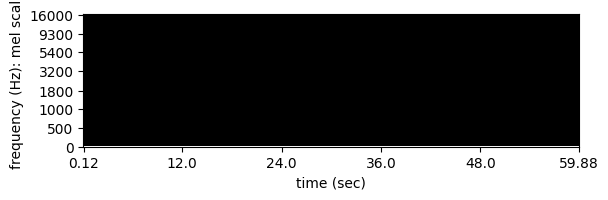

In [19]:
spec = MelSpectrogram.from_audio(
    Audio.from_file(soundscapes[0].as_posix(), sample_rate=32000),
    n_mels=128,
    fft_size=8192,
    window_samples=8000,
    overlap_fraction=0.5,
    # dont want to double log things
    dB_scale=False,
)
spec.plot()

In [26]:
spec.frequencies.shape, spec.times.shape, spec.spectrogram.shape

((128,), (479,), (128, 479))

(40, 479)


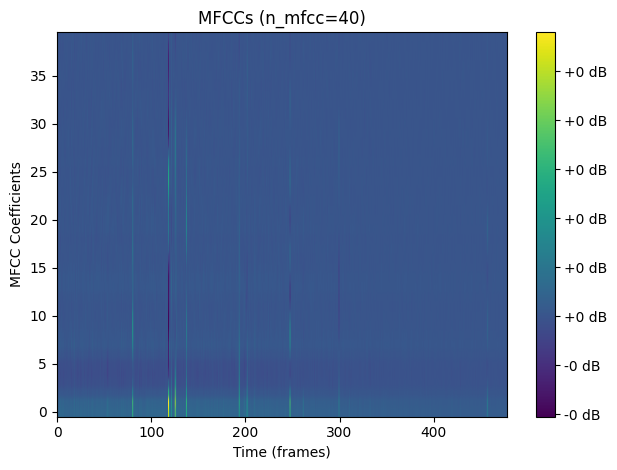

In [31]:
import librosa
import matplotlib.pyplot as plt

n_mfcc = 40

mfccs = librosa.feature.mfcc(
    S=spec.spectrogram,
    sr=spec.audio_sample_rate,
    n_mfcc=n_mfcc,
)
print(mfccs.shape)

plt.imshow(mfccs, aspect="auto", origin="lower")
plt.colorbar(format="%+2.0f dB")
plt.title(f"MFCCs (n_mfcc={n_mfcc})")
plt.xlabel("Time (frames)")
plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()

In [45]:
# let's save the mfcc as a pandas dataframe
import pandas as pd

# file, start_time, end_time, mfcc
df = pd.DataFrame(
    {
        "file": [soundscapes[0].name] * mfccs.shape[1],
        "timestamp": spec.times,
        "mfcc": [mfccs[:, i] for i in range(mfccs.shape[1])],
    }
)
# add new columns to the beginning for aiod and time
df

,file,timestamp,mfcc
0,H02_20230420_074000.ogg,0.125,"[0.00012703182, 0.00010932899, 2.4617406e-05, ..."
1,H02_20230420_074000.ogg,0.250,"[9.31225e-05, 7.424237e-05, 1.2275372e-05, -2...."
2,H02_20230420_074000.ogg,0.375,"[9.887998e-05, 8.3324194e-05, 1.4683357e-05, -..."
3,H02_20230420_074000.ogg,0.500,"[0.00011701008, 0.00010169973, 2.1569118e-05, ..."
4,H02_20230420_074000.ogg,0.625,"[0.00010271531, 8.79141e-05, 1.82951e-05, -2.8..."
...,...,...,...
474,H02_20230420_074000.ogg,59.375,"[4.524536e-05, 3.2659675e-05, 1.4064499e-06, -..."
475,H02_20230420_074000.ogg,59.500,"[4.233537e-05, 3.229821e-05, 5.286496e-06, -1...."
476,H02_20230420_074000.ogg,59.625,"[3.731503e-05, 2.7080547e-05, 4.5019697e-06, -..."
477,H02_20230420_074000.ogg,59.750,"[3.7184454e-05, 2.7319256e-05, 3.615146e-06, -..."
